In [1]:
from torch.distributions import Normal
import torch.optim as optim
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import gymnasium
import imageio
import random
import json

In [3]:
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, action_dim)
        )
        self.log_std = nn.Parameter(torch.zeros(action_dim))

    def forward(self, state):
        mean = self.network(state)
        log_std = self.log_std.expand_as(mean)
        std = torch.exp(log_std)
        return Normal(mean, std)


class ValueNetwork(nn.Module):
    def __init__(self, state_dim):
        super(ValueNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, state):
        return self.network(state)

In [4]:
class PPO:
    def __init__(self, state_dim, action_dim, clip_eps):
        self.gamma = 0.99  # discount factor for future rewards
        self.lam = 0.95  # lambda for generalized advantage estimation (GAE)
        self.num_epochs = 10  # number of times to iterate through the training data
        self.minibatch_size = 64  # size of minibatch from the training data
        self.clip_eps = clip_eps  # epsilon for clipping in the PPO objective
        self.policy_net = PolicyNetwork(state_dim, action_dim)
        self.val_net = ValueNetwork(state_dim)
        self.learning_rate = 3e-4
        self.policy_optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)
        self.value_optimizer = optim.Adam(self.val_net.parameters(), lr=self.learning_rate)

    def select_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0)
        dist = self.policy_net(state)
        action = dist.sample().squeeze(0)
        log_prob = dist.log_prob(action).squeeze()
        return action.numpy(), log_prob

    def compute_rewards_to_go(self, rewards, masks):
        rtg = []
        discounted_sum = 0
        for reward, mask in zip(reversed(rewards), reversed(masks)):
            discounted_sum = reward + self.gamma * discounted_sum * mask
            rtg.insert(0, discounted_sum)
        return torch.tensor(rtg)

    def compute_advantages(self, states, rewards, masks):
        values = self.val_net(torch.FloatTensor(states)).squeeze().detach()

        T = len(rewards)
        advantages = torch.zeros(T, dtype=torch.float32)
        gae = 0.0
        for t in reversed(range(T - 1)):
            td_error = rewards[t] + self.gamma * values[t + 1] * masks[t + 1] - values[t]
            gae = td_error + self.gamma * self.lam * gae * masks[t]
            advantages[t] = gae

        # normalize advantages to have 0 mean and unit variance to improve training stability
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-10)
        return advantages

    def update(self, states, actions, log_probs_old, rewards_to_go, advantages):
        total_samples = len(states)
        indices = torch.randperm(total_samples)

        for _ in range(self.num_epochs):
            for i in range(0, total_samples, self.minibatch_size):
                # extract minibatch
                batch_indices = indices[i:i + self.minibatch_size]
                states_batch = torch.FloatTensor(states)[batch_indices]
                actions_batch = torch.FloatTensor(actions)[batch_indices]
                old_log_probs_batch = torch.FloatTensor(log_probs_old)[batch_indices]
                rewards_to_go_batch = torch.FloatTensor(rewards_to_go)[batch_indices]
                advantages_batch = torch.FloatTensor(advantages)[batch_indices]

                # recalculate log probabilities for current policy
                dist = self.policy_net(states_batch)
                new_log_probs = dist.log_prob(actions_batch).squeeze()

                # calculate the ratio of new to old probabilities
                ratios = torch.exp(new_log_probs - old_log_probs_batch)

                # clipping the ratio to stabilize training
                clipped_ratios = torch.clamp(ratios, 1 - self.clip_eps, 1 + self.clip_eps)

                # calculate the clipped and unclipped objective
                unclipped_objective = ratios * advantages_batch
                clipped_objective = clipped_ratios * advantages_batch

                # negative sign to run gradient ascent
                policy_loss = -torch.min(unclipped_objective, clipped_objective).mean()

                # update policy network
                self.policy_optimizer.zero_grad()
                policy_loss.backward()
                self.policy_optimizer.step()

                # value function loss
                value_preds = self.val_net(states_batch).squeeze()
                value_loss = nn.MSELoss()(value_preds, rewards_to_go_batch)

                # update value network
                self.value_optimizer.zero_grad()
                value_loss.backward()
                self.value_optimizer.step()

In [5]:
def train_agent(agent, clip_eps, seed=1):
    rewards_over_episodes = []
    timestep = 0  # counter to keep track of total timesteps across all episodes

    while timestep < 2000:
        # lists to hold states, actions, rewards, log probabilities, and masks for the current episode
        states, actions, rewards, log_probs, masks = [], [], [], [], []
        multiple_episode_rewards = []  # rewards for multiple episodes within the loop
        episode_reward = []  # rewards for the current episode

        state, _ = env.reset(seed=seed)

        for t in range(T):
            action, log_prob = agent.select_action(state)
            next_state, reward, terminated, truncated, info = env.step(action)

            done = terminated or truncated
            mask = 0 if done else 1

            states.append(state)
            actions.append(action)
            rewards.append(reward)
            log_probs.append(log_prob)
            masks.append(mask)

            episode_reward.append(reward)
            state = next_state
            
            # if the episode is done, reset the environment and update episode counts
            if done:
                multiple_episode_rewards.append(len(episode_reward))
                episode_reward = []
                state, _ = env.reset(seed=seed)

        timestep += len(multiple_episode_rewards)

        # compute rewards-to-go and advantages for the collected data
        rewards_to_go = agent.compute_rewards_to_go(rewards, masks)
        advantages = agent.compute_advantages(states, rewards, masks)

        # perform a policy update using the collected data and computed rtg & advantages
        agent.update(states, actions, log_probs, rewards_to_go, advantages)
        
        # extend the main list with the rewards from this batch of episodes
        rewards_over_episodes.extend(multiple_episode_rewards)

        print(f"\r[Eps: {clip_eps}, Seed {seed}] Timestep {timestep}", end="")

    return rewards_over_episodes

In [6]:
env = gymnasium.make("InvertedPendulum-v4", render_mode="rgb_array")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

clip_epsilons = [0.1, 0.2, 0.3]
seeds = [1, 2, 3, 5, 8]
results = {}
T = 2048  # number of timesteps per episode

In [ ]:
for clip_eps in clip_epsilons:
    rewards_over_seeds = []

    for seed in seeds:
        # set seeds to ensure reproducibility
        torch.manual_seed(seed)
        random.seed(seed)
        np.random.seed(seed)

        agent = PPO(state_dim, action_dim, clip_eps=clip_eps)
        rewards_over_episodes = train_agent(agent, clip_eps, seed)

        rewards_over_seeds.append(rewards_over_episodes)
    results[clip_eps] = rewards_over_seeds

Saving the dictionary to a JSON file

In [ ]:
with open("training_results.json", "w") as json_file:
    json.dump(results, json_file, indent=4)

Loading the dictionary back from the JSON file

In [7]:
with open("training_results.json", "r") as json_file:
    loaded_results = json.load(json_file)

Performance of the PPO algorithm across different epsilon values

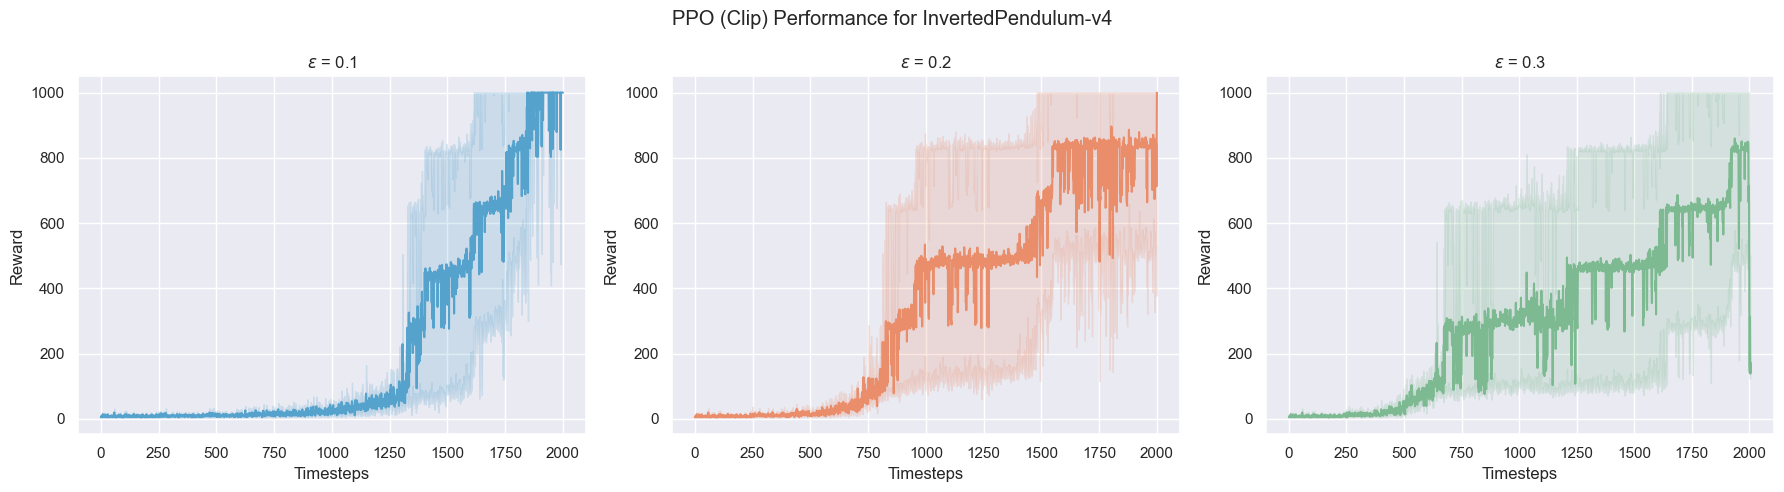

In [9]:
plt.figure(figsize=(18, 5))

for i, ((clip_eps, rewards), palette) in enumerate(zip(loaded_results.items(), ["flare", "crest", "icefire"])):
    plt.subplot(1, 3, i + 1)
    df = pd.DataFrame(rewards).melt()
    df.rename(columns={"variable": "Timesteps", "value": "Reward"}, inplace=True)
    sns.set(style="darkgrid", palette=palette)
    ax = sns.lineplot(x="Timesteps", y="Reward", data=df)
    ax.set(title=f"$\epsilon$ = {clip_eps}")

plt.suptitle("PPO (Clip) Performance for InvertedPendulum-v4")
plt.tight_layout()
plt.show()

In [10]:
clip_eps_avg_last_100 = {clip_eps: np.mean([np.mean(seed_rewards[-100:]) for seed_rewards in rewards])
                         for clip_eps, rewards in loaded_results.items()}

for clip_eps, avg_last_100 in clip_eps_avg_last_100.items():
    print(f"Clipping, ε={clip_eps}: {avg_last_100:.3f}")

Clipping, ε=0.1: 984.212
Clipping, ε=0.2: 826.082
Clipping, ε=0.3: 775.064


In [11]:
# training with ε=0.1 because it achieved the highest average reward
torch.manual_seed(1)
random.seed(1)
np.random.seed(1)
agent = PPO(state_dim, action_dim, clip_eps=0.1)
rewards_over_episodes = train_agent(agent, clip_eps=0.1)

[Eps: 0.1, Seed 1] Timestep 2000

Generate an animation showing the behavior of the trained agent in the environment

In [12]:
frames = []
state, _ = env.reset()
done = False

while not done:
    action, log_prob = agent.select_action(state)

    state, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    frame = env.render()
    frames.append(frame)

imageio.mimsave("inverted_pendulum.gif", frames, fps=30)
env.close()